In [ ]:
####YOLOV5folder_link: https://drive.google.com/drive/folders/1aFog87Zpl3i0H9GXlsYaO_r5sn7kuf4O?usp=sharing
####weight_file_link: https://drive.google.com/file/d/1yqHmuobm6ZLexsF6MYM8o9eY4H8SSXwy/view?usp=sharing
####dataset_link: https://drive.google.com/drive/folders/18Ya2cBVHWyL1DKNmYmJCq_200yr0RrTc?usp=sharing

In [4]:
from google.colab import drive
import os

# Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
model_path = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/train/exp19/weights/updated_best.pt"
train_folder = "/content/drive/MyDrive/Colab Notebooks/PennFudanPed/PNGImages/train"
val_folder = "/content/drive/MyDrive/Colab Notebooks/PennFudanPed/PNGImages/val"
os.chdir('/content/drive/MyDrive/Colab Notebooks/yolov5')#change this to your yolov5 folder
#The function `os.chdir()` is used to change the current working directory.
#this is necessary for the subsequent installation of ultralytics due to version differences.

In [27]:
#import sys
#sys.path.insert(0, "/content/drive/MyDrive/Colab Notebooks/yolov5")

Total number of training images: 118
Total number of training labels: 118
Total number of validation images: 52
Total number of validation labels: 52
Size of image 1: (456, 383)
Size of image 2: (266, 342)
Size of image 3: (302, 363)
Size of image 4: (385, 426)
Size of image 5: (479, 378)
Size of image 6: (539, 381)
Size of image 7: (459, 420)
Size of image 8: (490, 378)
Size of image 9: (425, 369)
Size of image 10: (253, 323)


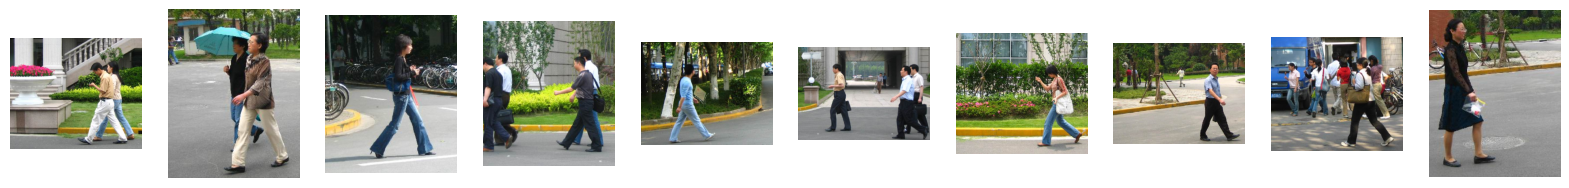

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

train_files = os.listdir(train_folder)
val_files = os.listdir(val_folder)

train_images = [file for file in train_files if file.endswith('.png')]
train_labels = [file for file in train_files if file.endswith('.txt')]
val_images = [file for file in val_files if file.endswith('.png')]
val_labels = [file for file in val_files if file.endswith('.txt')]

print(f'Total number of training images: {len(train_images)}')
print(f'Total number of training labels: {len(train_labels)}')
print(f'Total number of validation images: {len(val_images)}')
print(f'Total number of validation labels: {len(val_labels)}')

image_sizes = []
for image_name in train_images[:10]:
    image_path = os.path.join(train_folder, image_name)
    with Image.open(image_path) as img:
        width, height = img.size
        image_sizes.append((width, height))

for i, size in enumerate(image_sizes):
    print(f'Size of image {i+1}: {size}')

fig = plt.figure(figsize=(20, 20))
for i, image_name in enumerate(train_images[:10]):
    image_path = os.path.join(train_folder, image_name)
    img = Image.open(image_path)
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [24]:
label_files = [file for file in train_files if file.endswith('.txt')]

for label_name in label_files[:10]:
    label_path = os.path.join(train_folder, label_name)
    print(f'Content of {label_name}:')
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            print(f'  Class id: {class_id}, Center coordinates: ({x_center}, {y_center}), Width: {width}, Height: {height}')
    print('\n')


Content of PennPed00024.txt:
  Class id: 0.0, Center coordinates: (0.2946210268948655, 0.53125), Width: 0.24205378973105135, Height: 0.7604166666666666


Content of PennPed00084.txt:
  Class id: 0.0, Center coordinates: (0.6108108108108108, 0.5449438202247191), Width: 0.4540540540540541, Height: 0.8314606741573034
  Class id: 0.0, Center coordinates: (0.8594594594594595, 0.49859550561797755), Width: 0.23783783783783785, Height: 0.8792134831460674
  Class id: 0.0, Center coordinates: (0.49864864864864866, 0.4957865168539326), Width: 0.12702702702702703, Height: 0.45786516853932585


Content of FudanPed00053.txt:
  Class id: 0.0, Center coordinates: (0.26709796672828096, 0.5181034482758621), Width: 0.1866913123844732, Height: 0.453448275862069
  Class id: 0.0, Center coordinates: (0.8207024029574861, 0.5198275862068965), Width: 0.2033271719038817, Height: 0.5224137931034483


Content of PennPed00029.txt:
  Class id: 0.0, Center coordinates: (0.24404761904761904, 0.5203349282296651), Widt

In [25]:
!pip install ultralytics#install ultralytics,and make sure the current working directory is yolov5

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients


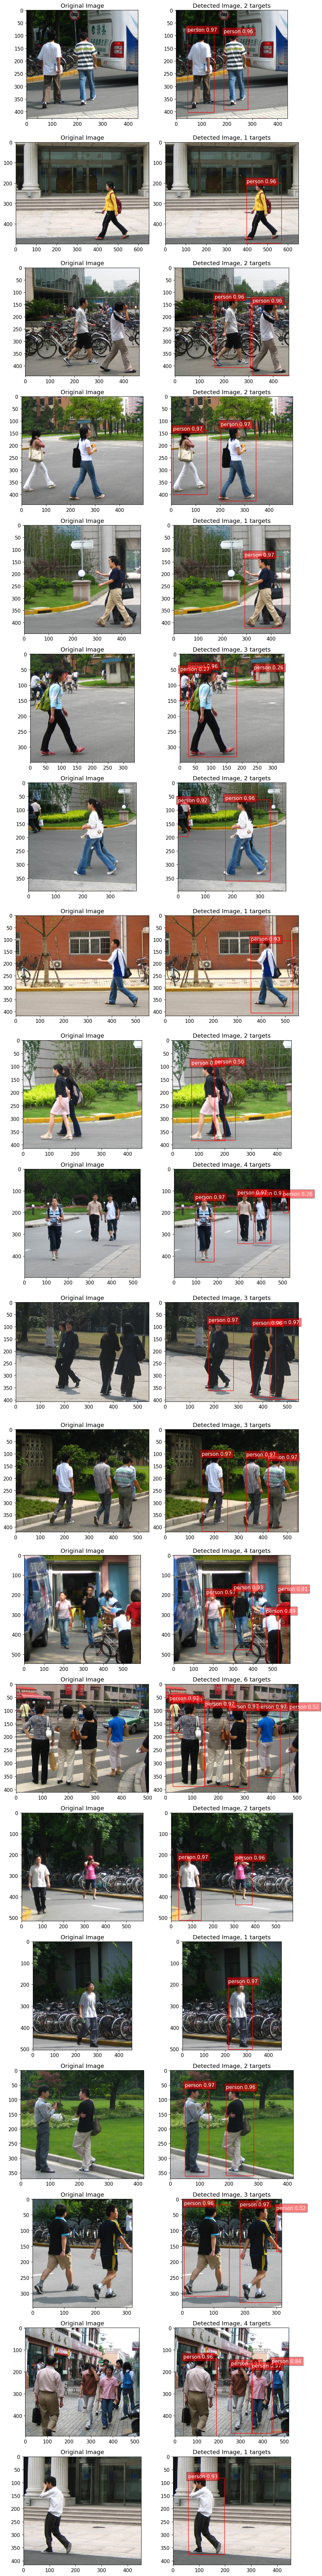

In [32]:
import numpy as np
from models.experimental import attempt_load
from utils.general import non_max_suppression
import torch
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = attempt_load(model_path)
model.to(device).eval()

# Get the paths of the first 20 images in the validation set
img_paths = [os.path.join(val_folder, file) for file in os.listdir(val_folder) if file.endswith('.png')][:20]

fig, axs = plt.subplots(len(img_paths), 2, figsize=(10, len(img_paths)*4))

for i, img_path in enumerate(img_paths):
    # Open image and get its size
    img = Image.open(img_path)
    w, h = img.size

    # Resize image
    w_new = ((w // 32) + 1) * 32 if w % 32 else w
    h_new = ((h // 32) + 1) * 32 if h % 32 else h
    img_resized = img.resize((w_new, h_new))

    # Convert to tensor
    img_tensor = torch.from_numpy(np.array(img_resized)).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        pred = model(img_tensor)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.25, 0.45)

    # Display original image
    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original Image')

    # Display detected objects on the original image
    num_targets = 0
    for *xyxy, conf, cls in pred[0]:
        num_targets += 1
        xmin, ymin, xmax, ymax = xyxy
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        axs[i, 1].add_patch(rect)
        axs[i, 1].text(xmin, ymin, f'{model.names[int(cls)]} {conf:.2f}', color='white', bbox=dict(facecolor='red', alpha=0.5))
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(f'Detected Image, {num_targets} targets')

plt.tight_layout()
plt.show()


In [18]:
# For counting the person in the image
# Output: dictory {"file_path": num_person, ...}
persons_counting={}
with open("/content/drive/MyDrive/Colab Notebooks/PennFudanPed/val_images.txt", "r") as f:
  lines = f.readlines()
  for line in lines:
    new_line = line.strip().replace(".png", ".txt")
    with open("/content/drive/MyDrive/Colab Notebooks/PennFudanPed/val_images.txt", "r") as t:
      lines_txt = t.readlines()
      num_people = len(lines_txt)
    persons_counting[line.strip()] = num_people
print(persons_counting)

{'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00002.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00003.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00004.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00009.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00013.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00015.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00019.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00020.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00026.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00028.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\FudanPed00031.png': 52, 'C:\\Users\\JoePride\\Desktop\\PennFudanPed\\PNGImages\\val\\Fud

In [19]:
# Calculating the iou
def calculate_intersection_over_union(prediction, target):
    # prediction, target are all [x_min, y_min, x_max, y_max]
    x_min = max(prediction[0], target[0])
    y_min = max(prediction[1], target[1])
    x_max = min(prediction[2], target[2])
    y_max = min(prediction[3], target[3])

    # calculate the area in pixel indexs
    intersection_area = max(0, x_max - x_min + 1) * max(0, y_max - y_min + 1)

    prediction_area = (prediction[2] - prediction[0] + 1) * (prediction[3] - prediction[1] + 1)
    target_area = (target[2] - target[0] + 1) * (target[3] - target[1] + 1)

    return intersection_area / float(prediction_area + target_area - intersection_area)

In [20]:
def compute_detection_accuracy(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [{key: value.to(device) for key, value in annotation.items()} for annotation in targets]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_scores = output['scores']
                target_boxes = target['boxes']
                target_labels = target['labels']

                # iou threshold = 0.8 * target_area
                iou_threshold = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1]) * 0.8

                # Calculate IoU between predicted boxes and ground truth boxes
                iou = calculate_intersection_over_union(pred_boxes, target_boxes)

                # Determine correct detections based on IoU threshold and label correctness
                pred_labels = pred_scores.argmax(dim=1)
                correct_detection = (iou >= iou_threshold) & (pred_labels == target_labels.view(-1, 1))
                correct += correct_detection.sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(f'Detection accuracy: {accuracy:.2f}')